# HeartAttackPredictor

This Jupyter Notebook utilizes data from [Kaggle](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset) to predict heart attack risk.  This ML pipeline was made for DSCI 631 at Drexel University for the Summer 2021 Quarter.  This notebook, and all relevant files, are available to the public on [Github](https://github.com/zachcarlson/HeartAttackPredictor).



## Group Information

### Team Members:

- Zach Carlson, [zc378@drexel.edu](mailto:zc378@drexel.edu)
- Andrew Napolitano, [a.napolitano.drexel@gmail.com](mailto:a.napolitano.drexel@gmail.com) or [asn65@drexel.edu](mailto:asn65@drexel.edu)
- Tyler Bread, [tb3245@drexel.edu](mailto:tb3245@drexel.edu)

## EDA and pipeline set-up
### Import packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
np.random.seed(42)

### Create functions

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def performance_output(df, df_labels, grid_search, model_name = ""):
    '''df:          test dataset
       df_labels:   test dataset labels
       grid_search: optimized grid_search
       model_name:  title for print out'''
    df_predict = grid_search.predict(df)
    f1 = f1_score(df_predict, df_labels)
    precision = precision_score(df_predict, df_labels)
    recall = recall_score(df_predict, df_labels)
    print(f"{model_name.upper()}\nBest Parameters: {grid_search.best_params_}\n")
    print(f"Accuracy Score: {grid_search.best_score_}\nPrecision Score: {precision}")
    print(f"Recall Score: {recall}\nF1 Score: {f1}")
    print(f"Confusion Matrix: \n{confusion_matrix(df_predict, df_labels)}")

In [5]:
def balance_output(df, target_column = "output", risk_value = 1, not_risk_value = 0):
    '''df:              dataset
      target_column:   column with target output values
      risk_value:      target value that corresponds to an "at risk" output
      not_risk_value:  target value that corresponds to a "not at risk" output''' 
    risk = len(df[df[target_column] == risk_value])
    no_risk = len(df[df[target_column] == not_risk_value])
    total = risk+no_risk
    print(f"Percentage Not Risk: {no_risk/total*100}%")
    print(f"Percentage Risk: {risk/total*100}%")

### Import data and inspect dataset

In [6]:
import pandas as pd

heart = pd.read_csv("./data/heart.csv")

In [7]:
heart.head()  #all numeric values, output is the target value which is categorical with a 0 (no risk) or a 1 (risk)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [8]:
heart.info() #no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


**Observations:**
- All features have datatype `int64`, expect `oldpeak`, which has the datatype `float64`.
- No missing/null values.
- 303 instances with 13 features and 1 target feature (`output`).

In [9]:
heart.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Distribution Analysis

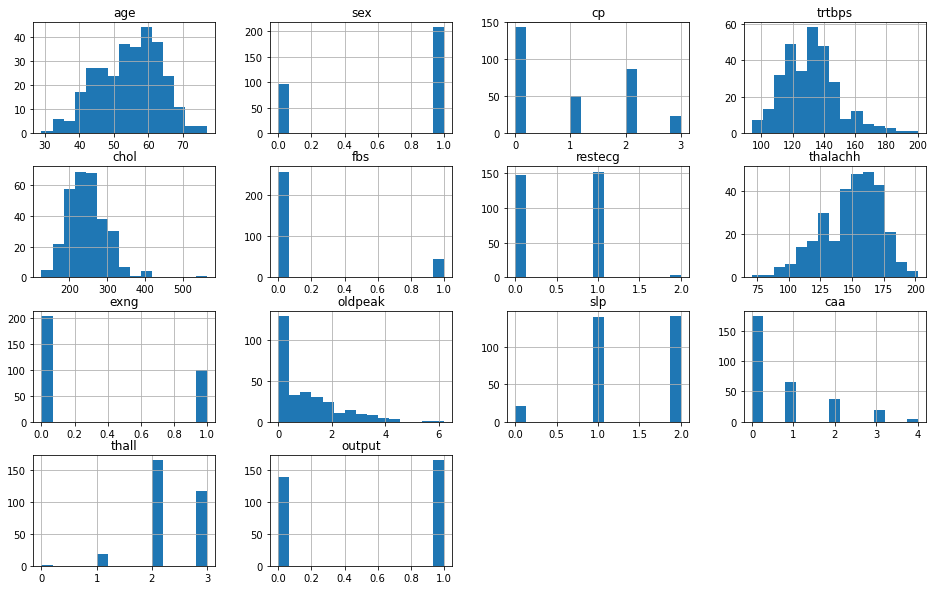

In [10]:
#visualize all features to see distributions
%matplotlib inline
import matplotlib.pyplot as plt
heart.hist(bins=15, figsize=(16,10)) #figsize = (width, height)
plt.show()

**Observations:**
- Scales for the features are different, will require feature scaling. 
- Distributions are not normally distributed (i.e. Gaussian), `StandardScaler` shouldn't be used to scale the data.  We'll use `MinMaxScaler` instead.
- After visualizing the feature distributions, it's clear several numeric features are categorical (i.e. discrete)
- **Categorical Features:** `sex`, `cp`, `fbs`, `restecg`, `exng`, `slp`, `caa`, `thall`, and `output`.  
- **Continuous Features:** `age`, `trtbps`, `chol`, `thalachh`, `oldpeak`.  

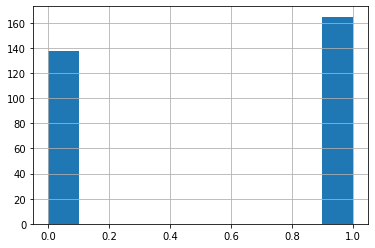

Percentage Not Risk: 45.54455445544555%
Percentage Risk: 54.45544554455446%


In [11]:
heart["output"].hist()
plt.show()
balance_output(heart)

**Observations:**
- The two different target values are similar.  This is not a very imbalanced dataset.
- Upsampling, downsampling, SMOTE, etc. may provide *some* performance improvement.

### Split Data

In [12]:
#split data into test and training sets
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(heart,                         #data frame to split
                                       test_size=0.2,                       #size of test set (proportion)
                                       random_state=42,                     #ensure reproducibility
                                       stratify=heart[["sex"]])    

heart = train_set.copy()

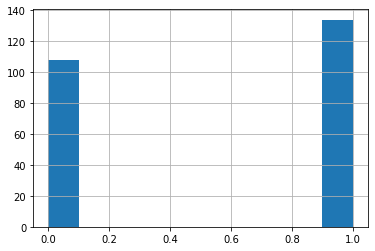

Percentage Not Risk: 44.62809917355372%
Percentage Risk: 55.371900826446286%


In [13]:
#assess distribution of target value in training and test set
train_set["output"].hist()
plt.show()
balance_output(train_set)

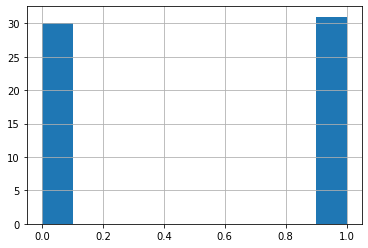

Percentage Not Risk: 49.18032786885246%
Percentage Risk: 50.81967213114754%


In [14]:
test_set["output"].hist()
plt.show()
balance_output(test_set)

**Observations:**

- The `train_set` has a 45/55 split.  There is no need to adjust the `train_set`.
- The `test_set` has a near-perfect 50/50 split (is 49.1/50.8).  There is no need to adjust the `test_set`.

### Colinearity Analysis

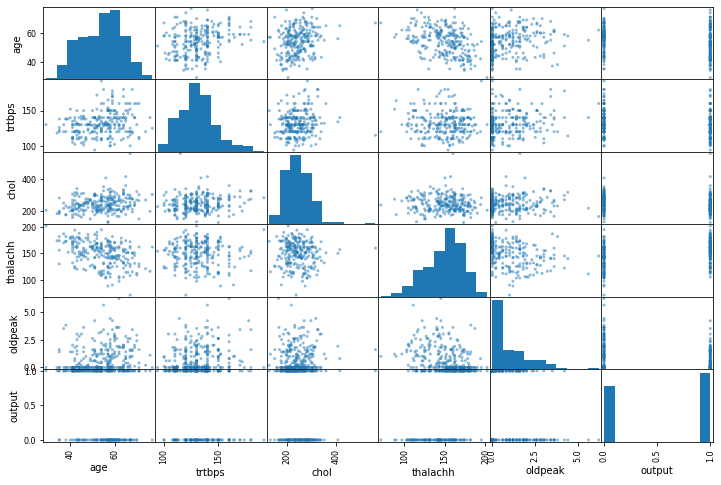

In [15]:
#can also create a scatter matrix to visualize all correlations at once
from pandas.plotting import scatter_matrix

attributes = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'output']
scatter_matrix(heart[attributes], figsize=(12, 8))
plt.show()

In [16]:
#see if there is a correlation
corr_matrix = heart[attributes].corr()

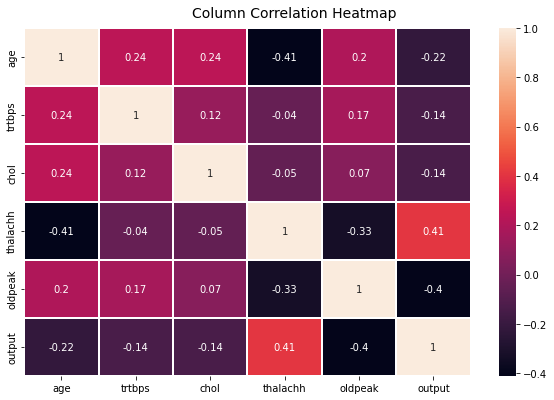

In [17]:
f, ax = plt.subplots(figsize=(10, 6))
hm = sns.heatmap(round(corr_matrix,2), annot=True, ax=ax,
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Column Correlation Heatmap', fontsize=14)

**Observations:**
- Little to no colinearity between non-target features.  
- The highest is `age` and `thalachh` with a value of `-0.36`. 
- Next is `oldpeak` with `thalachh` with a value of `-0.34`.
- Highest correlation with `output` is `thalachh` with a value of `0.41`.
- Can remove `oldpeak`, considering its multilinearity and its correlation with `thalachh` is slightly lower.

In [18]:
def drop_colinearity(df, df_labels, col_drop = []):
    df_drop = df.drop(col_drop, axis=1)
    df_labels_drop = df_labels.drop(col_drop, axis=1)
    return df_drop, df_labels_drop

### Final Data Preparations

In [19]:
#prepare data for machine learning algorithms
heart = train_set.drop("output", axis=1)
heart_labels = train_set["output"].copy()
heart_test = test_set.drop("output", axis=1)
test_labels = test_set["output"].copy()
cat_heart = heart[["sex", "cp", "fbs", "restecg", "exng", "slp", "caa", "thall"]]   #separate categorical
cont_heart = heart[["age", "trtbps", "chol", "thalachh", "oldpeak"]]                #separate continuous

In [20]:
heart_reduc, heart_test_reduc = drop_colinearity(heart, heart_test, ["oldpeak"]) 

### Build Pipeline

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler


numeric_attribs = list(cont_heart)
cat_attribs = list(cat_heart)
encoder = OneHotEncoder(handle_unknown = "ignore")

numeric_pipeline = Pipeline([
    ("scaler", MinMaxScaler())
])

full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_attribs),
    ("cat", encoder, cat_attribs)
])

heart_pipeline = full_pipeline.fit_transform(heart) #fit training data to pipeline

test_pipeline = full_pipeline.transform(heart_test) #transform testing data so the feature space is the same

In [22]:
heart_pipeline.shape

(242, 30)

## Train Machine Learning Algorithms
### Logistic Regression

In [23]:
# Optimize Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid=[
    {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
     "penalty":["l1","l2"], # l1 lasso l2 ridge
     "solver": ['liblinear']}
] 

log_reg = LogisticRegression(random_state = 42)
grid_search_log = GridSearchCV(log_reg, param_grid, cv=10, scoring="accuracy", return_train_score=True)

In [24]:
grid_search_log.fit(heart_pipeline, heart_labels)
performance_output(test_pipeline, test_labels, grid_search_log, "logistic regression")

LOGISTIC REGRESSION
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Accuracy Score: 0.8510000000000002
Precision Score: 0.9032258064516129
Recall Score: 0.8235294117647058
F1 Score: 0.8615384615384616
Confusion Matrix: 
[[24  3]
 [ 6 28]]


In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

kf = KFold(shuffle=True, n_splits=7)
log_scores = cross_val_score(grid_search_log, heart_pipeline, heart_labels,
                        scoring="accuracy", cv=kf)
log_scores.mean()


0.8264105642256903

In [26]:
from sklearn.metrics import classification_report

logreg_results = grid_search_log.predict(test_pipeline)
print(classification_report(test_labels, logreg_results))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        30
           1       0.82      0.90      0.86        31

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



#### Linear Regression with `oldpeak` Removed

In [27]:
numeric_attribs.remove("oldpeak")

In [28]:
full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_attribs),
    ("cat", encoder, cat_attribs)
])

heart_pipeline_drop = full_pipeline.fit_transform(heart_reduc) #fit training data to pipeline
test_pipeline_drop = full_pipeline.transform(heart_test_reduc) #transform testing data so the feature space is the same

grid_search_log.fit(heart_pipeline_drop, heart_labels)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             return_train_score=True, scoring='accuracy')

In [29]:
#def performance_output(df, df_labels, grid_search, model_name = ""):
performance_output(heart_pipeline_drop, heart_labels, grid_search_log, "LOGISTIC REGRESSION w/ FEATURE SELECTION")

LOGISTIC REGRESSION W/ FEATURE SELECTION
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

Accuracy Score: 0.8515
Precision Score: 0.9029850746268657
Recall Score: 0.8768115942028986
F1 Score: 0.8897058823529412
Confusion Matrix: 
[[ 91  13]
 [ 17 121]]


In [30]:
logreg_results_drop = grid_search_log.predict(test_pipeline_drop)
print("LOGISTIC REGRESSION w/ FEATURE SELECTION")
print(classification_report(test_labels, logreg_results_drop))

LOGISTIC REGRESSION w/ FEATURE SELECTION
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.83      0.94      0.88        31

    accuracy                           0.87        61
   macro avg       0.88      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



### Softmax Regression

In [31]:
param_grid=[
    {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
     "penalty":["l2"], # l1 lasso l2 ridge
     "solver": ['lbfgs'],
    "multi_class":['multinomial']}
] 


softmax_reg = LogisticRegression(random_state=42)
grid_search_smr = GridSearchCV(log_reg, param_grid, cv=10, scoring="accuracy", return_train_score=True)
grid_search_smr.fit(heart_pipeline_drop, heart_labels)
performance_output(test_pipeline_drop, test_labels, grid_search_smr, "softmax regression")

SOFTMAX REGRESSION
Best Parameters: {'C': 10, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}

Accuracy Score: 0.8515
Precision Score: 0.9354838709677419
Recall Score: 0.8285714285714286
F1 Score: 0.8787878787878788
Confusion Matrix: 
[[24  2]
 [ 6 29]]


In [32]:
kf = KFold(shuffle=True, n_splits=7)
softmax_scores = cross_val_score(grid_search_smr, heart_pipeline_drop, heart_labels,
                        scoring="accuracy", cv=kf)
softmax_scores.mean()

0.8265306122448978

In [33]:
from sklearn.metrics import classification_report

softmax_results = grid_search_smr.predict(test_pipeline_drop)
print(classification_report(test_labels, softmax_results))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.83      0.94      0.88        31

    accuracy                           0.87        61
   macro avg       0.88      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



**Observations:**

- Softmax Regression (i.e. setting `multi_class` to `multinomial` and setting `solver` to `lbfgs`) improves accuracy by ~1%
- Removing `oldpeak` improves accuracy by 2%.  We will use `heart_pipeline_drop` and `test_pipeline_drop` going forward.

### Random Forest

In [34]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200]
}


rnd_clf = RandomForestClassifier(random_state = 42, verbose = 0)
grid_search_rnd = GridSearchCV(rnd_clf, param_grid, 
                          cv = 3, n_jobs = -1, verbose = 0)
grid_search_rnd.fit(heart_pipeline_drop, heart_labels)
performance_output(test_pipeline_drop, test_labels, grid_search_rnd, "random forest")

RANDOM FOREST
Best Parameters: {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 100}

Accuracy Score: 0.8677469135802469
Precision Score: 0.9354838709677419
Recall Score: 0.7837837837837838
F1 Score: 0.8529411764705881
Confusion Matrix: 
[[22  2]
 [ 8 29]]


In [35]:
rnd_results = grid_search_rnd.predict(test_pipeline_drop)
print(classification_report(test_labels, rnd_results))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        30
           1       0.78      0.94      0.85        31

    accuracy                           0.84        61
   macro avg       0.85      0.83      0.83        61
weighted avg       0.85      0.84      0.83        61



### Support Vector Classification (SVC)

In [36]:
svc_clf = SVC(random_state = 42)

param_grid = {
    'C': [0.1, 10, 1000],
    'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'gamma': [0.001, 0.01, 0.1, 1],
}

grid_search_svc = GridSearchCV(svc_clf, param_grid, 
                          cv = 3, n_jobs = -1, verbose = 0)

In [37]:
grid_search_svc.fit(heart_pipeline_drop, heart_labels)
performance_output(test_pipeline_drop, test_labels, grid_search_svc, "random forest")

RANDOM FOREST
Best Parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}

Accuracy Score: 0.8470679012345679
Precision Score: 0.967741935483871
Recall Score: 0.8333333333333334
F1 Score: 0.8955223880597015
Confusion Matrix: 
[[24  1]
 [ 6 30]]


In [38]:
grid_search_svc.best_estimator_

SVC(C=0.1, gamma=0.001, kernel='linear', random_state=42)

In [39]:
svc_results = grid_search_svc.predict(test_pipeline_drop)
print(classification_report(test_labels, svc_results))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87        30
           1       0.83      0.97      0.90        31

    accuracy                           0.89        61
   macro avg       0.90      0.88      0.88        61
weighted avg       0.90      0.89      0.88        61



## Dimensionality Reduction

### PCA

In [40]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
pca.fit(heart_pipeline_drop)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

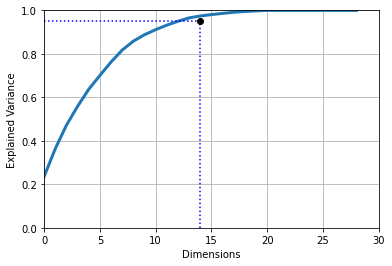

In [41]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 30, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "b:")
plt.plot([0, d], [0.95, 0.95], "b:")
plt.plot(d, 0.95, "ko")
plt.grid(True)
plt.show()

In [42]:
pca = PCA(n_components=0.95)
heart_reduced = pca.fit_transform(heart_pipeline_drop)
print(f"# Features to Maintain %95 variance: {pca.n_components_}")
print(f"Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_)}")

# Features to Maintain %95 variance: 14
Explained Variance Ratio: 0.965468965078703


**Observations:**

- You can maintain 95% of the variance in the original dataset using 14 features.

- Elbow is around 7 features or so.

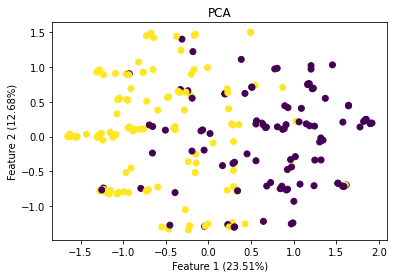

In [43]:
fig, ax = plt.subplots()

colors = {0: 'black', 1: 'red'}

plt.title("PCA")
plt.xlabel(f"Feature 1 (23.51%)")
plt.ylabel(f"Feature 2 (12.68%)")
groups = [0,1]
pca_plot = plt.scatter(heart_reduced[:,0], 
            heart_reduced[:,1], c=heart_labels)
plt.show()

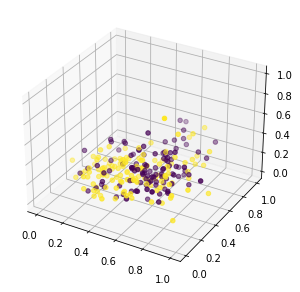

In [44]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(heart_pipeline_drop[:,0], heart_pipeline_drop[:,1], heart_pipeline_drop[:,2],
          c=heart_labels)
plt.show()

In [45]:
# Optimize PCA with Logistic Regression 
pca = PCA(random_state=42)
svc = SVC(random_state=42)

pipeline = Pipeline([
    ('pca', pca),
    ('svc', svc)
])

param_grid = {
    'pca__n_components': [5, 10, 14, 20, 25, 29],    #reduce to n features
    'pca__svd_solver': ['auto', 'full', "randomized"],  
    'svc__C': [0.1, 10, 1000],
    'svc__kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'svc__gamma': [0.001, 0.01, 0.1, 1],
    
}
grid_search_pca = GridSearchCV(pipeline, param_grid, n_jobs=-1)

In [46]:
grid_search_pca.fit(heart_pipeline_drop, heart_labels)
print(f"Best parameter (CV score={grid_search_pca.best_score_})")
print(grid_search_pca.best_params_)
print("-----")
performance_output(test_pipeline_drop, test_labels, grid_search_svc, "SVC ")
print("-----")
performance_output(test_pipeline_drop, test_labels, grid_search_pca, "SVC w/ PCA")

Best parameter (CV score=0.8432823129251702)
{'pca__n_components': 10, 'pca__svd_solver': 'auto', 'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
-----
SVC 
Best Parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}

Accuracy Score: 0.8470679012345679
Precision Score: 0.967741935483871
Recall Score: 0.8333333333333334
F1 Score: 0.8955223880597015
Confusion Matrix: 
[[24  1]
 [ 6 30]]
-----
SVC W/ PCA
Best Parameters: {'pca__n_components': 10, 'pca__svd_solver': 'auto', 'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

Accuracy Score: 0.8432823129251702
Precision Score: 0.8387096774193549
Recall Score: 0.8125
F1 Score: 0.8253968253968254
Confusion Matrix: 
[[24  5]
 [ 6 26]]


In [47]:
pca_results = grid_search_pca.predict(test_pipeline_drop)
print("PCA w/ SVC RESULTS")
print(classification_report(test_labels, pca_results))

PCA w/ SVC RESULTS
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        30
           1       0.81      0.84      0.83        31

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



**Observations:**

-  Reducing the dataset with `PCA` before fitting to a `SVC` model does not improve accuracy or recall compared to `SVC` alone.

This dataset is too small to run `IncrementalPCA` (only 300 instances).  The mini-batches would be 3 samples.  

### Kernel PCA

In [48]:
# Optimize KernelPCA with Logistic Regression and 
from sklearn.decomposition import KernelPCA

pca = KernelPCA()
svc = SVC()

pipeline = Pipeline([
    ('pca', pca),
    ('svc', svc)
])

param_grid = {
    'pca__n_components': [5, 10, 14, 20, 25, 29],    #reduce to n features
    'pca__kernel': ['rbf', 'linear', 'sigmoid', "poly"],
    'pca__gamma': np.linspace(0.03, 0.05, 10),
    'svc__C': [0.1, 10, 1000],
    'svc__kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'svc__gamma': [0.001, 0.01, 0.1, 1],
}
grid_search_kernelpca = GridSearchCV(pipeline, param_grid, n_jobs=-1)

In [49]:
grid_search_kernelpca.fit(heart_pipeline_drop, heart_labels)
print(f"Best parameter (CV score={grid_search_kernelpca.best_score_})")
print(grid_search_kernelpca.best_params_)

Best parameter (CV score=0.8762755102040817)
{'pca__gamma': 0.03666666666666667, 'pca__kernel': 'poly', 'pca__n_components': 25, 'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'sigmoid'}


In [50]:
kernelpca_results = grid_search_kernelpca.predict(test_pipeline_drop)
print("KERNEL PCA RESULTS")
print(classification_report(test_labels, kernelpca_results))

KERNEL PCA RESULTS
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        30
           1       0.82      0.90      0.86        31

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61



## Ensemble Learning
### XGBoost

In [51]:
import xgboost

xgb_clf = xgboost.XGBClassifier(verbose = 0, use_label_encoder = False)   #verbosity = 0 to hide warnings, use_label_encoder = False to ensure future reproducibility
xgb_clf.fit(heart_pipeline_drop, heart_labels)
xgb_clf.score(test_pipeline_drop, test_labels)

[16:07:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:07:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8360655737704918

In [52]:
xgb_results = xgb_clf.predict(test_pipeline_drop)
print(classification_report(test_labels, xgb_results))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        30
           1       0.84      0.84      0.84        31

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



### VotingClassifier

In [53]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score


voting_classifier = VotingClassifier(
    estimators=[
        ('log_reg', grid_search_log),
        #('random_forest', grid_search_rnd),
        ('svc', grid_search_svc),
        ('xgb', xgb_clf),   #excluding xgb_clf, it reduces the overall performance of voting_classifier (0.86885245)
    ])

voting_classifier.fit(heart_pipeline_drop, heart_labels)

for classifier in (log_reg, svc_clf, voting_classifier):
    classifier.fit(heart_pipeline_drop, heart_labels)                                   #fit the training set to the classifer
    test_pred = classifier.predict(test_pipeline_drop)   #get predictions from test set
    print(classifier.__class__.__name__, accuracy_score(test_labels, test_pred))   #assess accuracy

[16:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
LogisticRegression 0.8688524590163934
SVC 0.8524590163934426
[16:07:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pas

In [54]:
vc_results = voting_classifier.predict(test_pipeline_drop)
print("VOTING CLASSIFIER RESULTS")
print(classification_report(test_labels, vc_results))

VOTING CLASSIFIER RESULTS
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.83      0.94      0.88        31

    accuracy                           0.87        61
   macro avg       0.88      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



## Summary of ML Algorithm Reports

In [55]:
print("LOGISTIC REGRESSION RESULTS")
print(classification_report(test_labels, logreg_results))
print("-----------------------------------------------------")
print("SOFTMAX REGRESSION RESULTS")
print(classification_report(test_labels, softmax_results))
print("-----------------------------------------------------")
print("PCA w/ LOGISTIC REGRESSION RESULTS")
print(classification_report(test_labels, pca_results))
print("-----------------------------------------------------")
print("KERNEL PCA w/ LOGISTIC REGRESSION RESULTS")
print(classification_report(test_labels, kernelpca_results))
print("-----------------------------------------------------")
print("SVC RESULTS")
print(classification_report(test_labels, svc_results))
print("-----------------------------------------------------")
print("RANDOM FORESTS RESULTS")
print(classification_report(test_labels, rnd_results))
print("-----------------------------------------------------")
# print("XGBOOST RESULTS")
# print(classification_report(test_labels, xgb_results))
# print("-----------------------------------------------------")
print("VOTING CLASSIFIER RESULTS")
print(classification_report(test_labels, vc_results))
print("-----------------------------------------------------")

LOGISTIC REGRESSION RESULTS
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        30
           1       0.82      0.90      0.86        31

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61

-----------------------------------------------------
SOFTMAX REGRESSION RESULTS
              precision    recall  f1-score   support

           0       0.92      0.80      0.86        30
           1       0.83      0.94      0.88        31

    accuracy                           0.87        61
   macro avg       0.88      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61

-----------------------------------------------------
PCA w/ LOGISTIC REGRESSION RESULTS
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        30
           1       0.81      0.84      

**Observations:**

- The `VotingClassifier` gave the best accuracy score (`0.90`)
- The `SoftmaxRegression` improved the `LogisticRegression` accuracy score slightly. (original: `0.85`, softmax: `0.87`)
- Will attempt to combine the `PCA` slight improvement with the `VotingClassifer` slight improvement.

## Final Report and Conclusions

In [56]:
print("SVC RESULTS")
print(classification_report(test_labels, svc_results))
print("-----------------------------------------------------")

SVC RESULTS
              precision    recall  f1-score   support

           0       0.96      0.80      0.87        30
           1       0.83      0.97      0.90        31

    accuracy                           0.89        61
   macro avg       0.90      0.88      0.88        61
weighted avg       0.90      0.89      0.88        61

-----------------------------------------------------


**Final Observations:**
- The best estimator was the `SVC` with an `accuracy` score of `0.89` with a recall of `0.97`. 
- This is not bad, however depending on the context of where this ML pipeline will be utilized, it might be best to sacrifice accuracy in favor of recall or precision optimization.
- In the event the goal is to provide doctors or patients with a tool to identify heart attack risk in *every* patient who has a true value of "risk", it might be best to ensure the recall is as close to 100% as possible.
- ANNs may offer some hope of further improving the accuracy, however these algorithms where out-of-scope for this project and there was not time to implement them.
- Another potential source for improvement would be to increase the number of instances.  There are only 300, which is very small.  A larger dataset may provide the ML pipeline what it needs to make better predictions.